<font color=red>第一次参加kaggle比赛，得分为0.11356，排名在前4%</font>

<br>
原文链接 https://mp.weixin.qq.com/s/wbAjH_mjnkwHbp9o7wYIQA

## 问题描述：

基于kaggle网站所提供的爱荷华州埃姆斯的住宅数据信息，预测每间房屋的销售价格，数据的标签SalePrice是连续性数据，因此可以判定这是一个回归问题。

## 最终目标：
预测每一个房屋的销售价格。对于测试集中的每个ID，预测SalePrice变量的值

判定标准：根据预测值的对数与观察到的销售价格的对数之间的均方根误差（RMSE）评估提交的内容（采取对数意味着预测昂贵房屋和廉价房屋的错误将同等影响结果).

## 数据描述：

数据来源于kaggle网站。数据分为训练数据集和测试数据集。两个数据集都包括每栋房⼦的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚⾄是缺失值“na”。只有训练数据集包括了每栋房⼦的价格，也就是标签。

训练数据和测试数据分别各有1460条，数据的特征列有79个，期中35个是数值类型的，44个类别类型

## mount google drive folder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/house_price_predication'
%ls

/content/drive/MyDrive/house_price_predication
data_description.txt   house_price_predication.ipynb  test.csv
Dive-into-DL-PyTorch/  sample_submission.csv          train.csv


## install d2lzh_pytorch

In [3]:
!pip install -U d2l

     |████████████████████████████████| 81kB 3.9MB/s 


## 导入各种包

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import norm
from scipy import stats
import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
 
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.8.1+cu101


## 读取数据

In [6]:
##训练集
train_data=pd.read_csv(open('./train.csv'))
##测试集
test_data=pd.read_csv(open('./test.csv'))

## 数据可视化

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 <a list of 7 Text major ticklabel objects>)

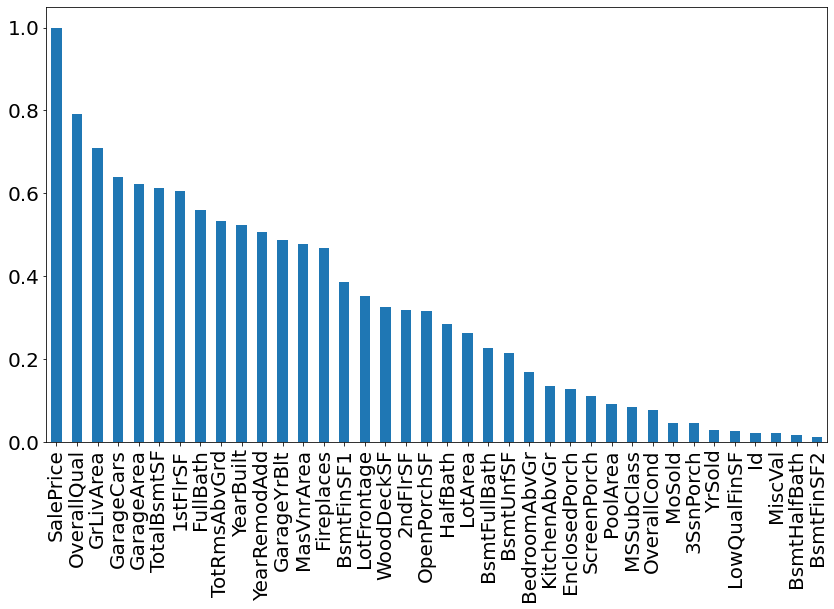

In [7]:
#查看自变量与因变量的相关性
fig = plt.figure(figsize=(14,8))
abs(train_data.corr()['SalePrice']).sort_values(ascending=False).plot.bar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

由上图可以发现有10个变量与因变量的相关性大于0.5，分别是：
- OverallQual 房屋设施的完整性

- GrLivArea 居住面积

- GarageCars  车库

- GarageArea  车库面积

- TotalBsmtSF 地下室大小

- 1stFlrSF 1楼面积

- FullBath 厕所面积

- TotRmsAbvGrd 地面上的房间数量

- YearBuilt 建造年份

- YearRemodAdd 重建年份


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


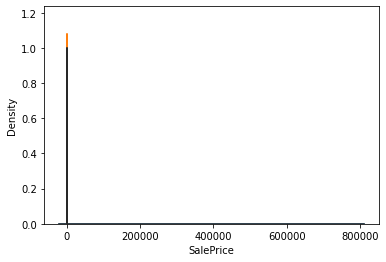

In [8]:
#查看因变量是否符合正态分布
sns.distplot(train_data['SalePrice'],fit=norm)
sns.distplot(np.log(train_data['SalePrice']),fit=norm)#取对数后的

取对数后发现基本符合正态分布，可以进行线性回归建模，但在这里先不做处理，建模的时候在取对数。

## 数据预处理

<Figure size 432x288 with 0 Axes>

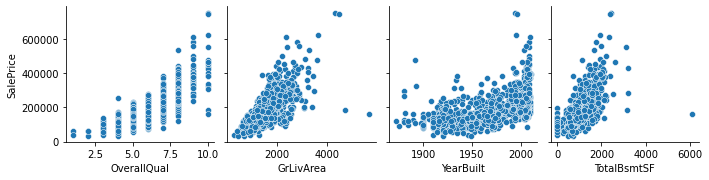

In [9]:
#异常值处理
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],
             y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

通过上面的散点图我们可以观察到训练数据存在一些离群点（异常值）比如：

1. OverallQual：总体质量评分小于5，销售价格却大于200000

2. GrLivArea：居住面积大于4000，销售价格却小于300000，根据我们的常识可以得知，一般来说居住面积越大，销售价格应该越高。

3. YearBuilt:建造年份在1900年之前的销售价格还可以大于400000

4. TotalBsmtSF：地下室总面积大于6000，销售价格还低于200000.

综合以上分析，我们将删除这些异常值。

In [10]:
#删除异常值
train_data = train_data.drop(train_data[(train_data['OverallQual']<5) &
                                        (train_data['SalePrice']>200000)].index)
 
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) &
                                        (train_data['SalePrice']<300000)].index)
 
train_data = train_data.drop(train_data[(train_data['YearBuilt']<1900) &
                                        (train_data['SalePrice']>400000)].index)
train_data = train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) &
                                        (train_data['SalePrice']<200000)].index)

<Figure size 432x288 with 0 Axes>

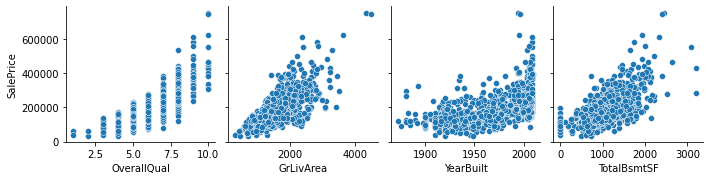

In [11]:
#检查是否还存在异常值
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],
             y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

异常值处理后发现数据没有其他明显的异常值

## 合并数据

In [12]:
#去掉Id和SalePrice,将训练集和测试集的79个特征按样本连接
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

分析数据得知，79列数据中有34列数据存在缺失值，但是大部分缺失值都在10%以下，而有5列数据缺失值接近或超过50%。分别是：

1. **PoolQC** 游泳池情况，取值有Excellent，Good，Fair，空值表示没有游泳池。
2. **MiscFeature** 房屋有的其他设施，取值有Shed(小屋)，Othr(其他)，Gar2(第二个车库)，TenC(乒乓球桌)，空值代表没有其他设施
3. **Alley** 小巷道路类型，取值有Grvl（碎石），paved(铺切面)。空值代表没有小巷
4. **Fence** 围墙类型，取值有GdPrv(Good Privacy)，MnPrv（Minimum Privacy），GdWo（Good Wood），MnWw（Minimum Wood），空值代表没有围墙
5. **FireplaceQu**，壁炉类型，取值有Ex(Excellent),Gd(Good),
6. Fa(Fair),Po(Poor),TA(Average),空值代表没有壁炉。

对于这些列，空值是有特别意义的，因此这些缺失值不可以删除。



In [13]:
#将列表中数值型的数据索引出来
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
#对数据进行标准化
all_features[numeric_features]=all_features[numeric_features].apply(
        lambda x:(x-x.mean())/(x.std()))
#标准化后，每个数值特征的均值变为0，可以直接用0来替换缺失值
all_features[numeric_features]=all_features[numeric_features].fillna(0)
#离散数值转成指示特征
all_features=pd.get_dummies(all_features,dummy_na=True)#通过转换将特征数从79增加到了330

数值型的数据，我们直接采用0来填充缺失值.

非数值型的数据，我们采用独热编码的方式转换成指示特征。比如，特征MSZoning里面有两个不同的离散值RL和RM，那么这一步将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM,其值为0或者1.如果一个样本在原来MSZoning里的值为RL，那么MSZoning_RL=1且MSZoning_RM=0.

## 模型建立和训练

![](https://img-blog.csdnimg.cn/20200525170705581.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3pfbWF3a2lzaA==,size_16,color_FFFFFF,t_70)

In [14]:
#先把合并的数据集重新分割为训练集和测试集
n_train=train_data.shape[0]
#通过values属性得到Numpy格式的数据，并转成Tensor方便后面的训练
#训练样本特征
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float)
#测试样本特征
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float)
#训练样本标签
train_labels=torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

In [15]:
#定义均方误差损失函数
loss=torch.nn.MSELoss()

In [21]:
#定义线性回归模型
def get_net(feature_num):
    net=nn.Sequential(
            d2l.FlattenLayer(),
            nn.Linear(feature_num,256),
            nn.ReLU(),
            nn.Linear(256,1),
            )
    #模型参数初始化
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

In [22]:
#对数均方误差的实现
def log_rmse(net,features,labels):
    with torch.no_grad():
        #将小于1的值设成1，使的取对数时数值更稳定
        clipped_preds=torch.max(net(features),torch.tensor(1.0))
        rmse=torch.sqrt(loss(clipped_preds.log(),labels.log()))
    return rmse.item()

测试集中的数据量m不同，因为有累加操作，所以随着数据的增加 ，误差会逐渐积累；因此衡量标准和 m 相关。为了抵消掉数据量的形象，可以除去数据量，抵消误差。通过这种处理方式得到的结果叫做均方误差MSE（Mean Squared Error）：均方误差MSE，定义如下：

![Image](https://img-blog.csdnimg.cn/20200525170123116.png)

上式中，yi为一个batch_size中第 i 个数据的正确答案，而为神经网络给出的预测值。

但是使用均方误差MSE受到量纲的影响。例如在衡量销售价格时，y的单位是（万元），那么衡量标准得到的结果是（万元平方）。为了解决量纲的问题，可以将其开方（为了解决方差的量纲问题，将其开方得到平方差）得到均方根误差RMSE（Root Mean Squarde Error）：

![Image](https://img-blog.csdnimg.cn/20200525170303252.png)

即便为了解决均方误差受到量纲的影响，采用的均方根误差，仍然存在其他影响，比如预测过程中昂贵房屋和廉价房屋的错误会给结果带来不同的影响，因此为解决这一问题，又引进对数均方差根误差，采取对数意味着预测昂贵房屋和廉价房屋的错误将同等影响结果。对数均方根误差：

![Image](https://img-blog.csdnimg.cn/20200525170359653.png)

In [23]:
def train(net,train_features,train_labels,test_features,test_labels,
          num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    #把dataset放入DataLoader
    dataset=torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    #这里使用了Adam优化算法
    optimizer=torch.optim.Adam(params=net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    net=net.float()#将神经网络中的数据类型设置维浮点型
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [24]:
#K折交叉验证
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        #划分出验证数据集
        if j==1:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        #划分出训练数据，剩下的进行合并
        else:
            X_train=torch.cat((X_train,X_part),dim=0)
            #dim=0按列合并
            y_train=torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid
def k_fold(k,X_train,y_train,num_epochs,
           learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net(X_train.shape[1])
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,
                                weight_decay,batch_size)
        #误差累计
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            d2l.semilogy(range(1,num_epochs+1),train_ls,
                         'epochs','rmse',
                         range(1,num_epochs+1),valid_ls,
                         ['train','valid'])
            #输出相应的结果：训练误差、验证误差
        print('fold%d,train rmse %f,valid rmse %f'%
              (i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

## 模型选择

In [25]:
#模型选择
k,num_epochs,lr,weight_decay,batch_size=8,100,0.1,300,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation:avg trian rmse %f,avg valid rmse %f'%
      (k,train_l,valid_l))

AttributeError: ignored

## 模型预测

In [ ]:
#模型预测
def train_and_pred(train_features,test_features,train_labeld,test_data,
                   num_epochs,lr,weight_decay,batch_size):
    net=get_net(train_features.shape[1])
    #第二个变量（测试误差）缺省，用_代替
    train_ls,_=train(net,train_features,train_labels,None,None,
                     num_epochs,lr,weight_decay,batch_size)
    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse')
    print('train rmse %f'%train_ls[-1])
    preds=net(test_features).detach().numpy()
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])
    submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('./submission.csv',index=False)

In [ ]:
train_and_pred(train_features,test_features,train_labels,
               test_data,num_epochs,lr,weight_decay,batch_size)

AttributeError: ignored